In [1]:
import pandas as pd
import random
import itertools
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns

Downloaded data from: http://web.mta.info/developers/turnstile.html

Documentations at: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

Map of the MTA system: http://web.mta.info/maps/submap.html

In [2]:
df = pd.read_csv('clean_turnstile_data.csv', low_memory=False)

/Users/kendra/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%Y-%m-%d %H:%M:%S')
df['DATE'] = pd.to_datetime(df['DATE'])
df['TOTAL'] = df['ENTRY_DIFFS'] + df['EXIT_DIFFS']
df['DAY_OF_WEEK'] = df['DATETIME'].dt.weekday
df.set_index('DATETIME', inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,DAY_OF_WEEK
DATETIME,,,,,,,,,,,,,,,,
2018-05-19 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,00:00:00,REGULAR,6625470,2245312,A002 R051 59 ST,24.0,2.0,26.0,5
2018-05-19 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,04:00:00,REGULAR,6625494,2245314,A002 R051 59 ST,20.0,24.0,44.0,5
2018-05-19 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,08:00:00,REGULAR,6625514,2245338,A002 R051 59 ST,81.0,77.0,158.0,5
2018-05-19 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,12:00:00,REGULAR,6625595,2245415,A002 R051 59 ST,196.0,66.0,262.0,5
2018-05-19 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,2018-05-19,16:00:00,REGULAR,6625791,2245481,A002 R051 59 ST,227.0,39.0,266.0,5


In [6]:
uni_stn_list = df['STATION'].unique()

Resample dataframe every 4 hours:

In [7]:
df2 = df.groupby(['STATION']).resample(rule='4H').sum().reset_index()

In [8]:
# Day of Week gets summed because it's a number. Re-compute
df2['DAY_OF_WEEK'] = df2['DATETIME'].dt.weekday
df2['DATE'] = df2['DATETIME'].dt.date
df2['TIME'] = df2['DATETIME'].dt.time

df2.drop(['ENTRIES','EXITS'], axis=1, inplace=True)

In [10]:
d_vs_e = ['wkday']*5 + ['wkend']*2
wkday_wkend_dict = dict(zip(range(7), d_vs_e))
df2['WKDAY_WKEND'] = df2['DAY_OF_WEEK'].map(wkday_wkend_dict)

In [ ]:
# If you need to re-save csv file, un-silence this.
# df2.to_csv('resampled_turnstile_data.csv')

### Sum over all data

to get a list of high-volume stations

In [11]:
grp2 = df2.groupby(['STATION'])['ENTRY_DIFFS','EXIT_DIFFS', 'TOTAL'].sum().reset_index()

In [198]:
highest_vol = list(set(grp2.sort_values('TOTAL').tail(16)['STATION']))
lowest_vol = list(set(grp2.sort_values('TOTAL').head(16)['STATION']))
rand_vol = list(set(grp2.sort_values('TOTAL').sample(16)['STATION']))

n = len(grp2)

mid_vol = list(set(grp2.sort_values('TOTAL').iloc[(n//2)-8:(n//2)+8]['STATION']))

## ANALYZE DATA

### Volume by 4-hr time slice

What stations experience the top volume in a 4-hr period?

Play with # in head() to get desired # of stations

In [13]:
top_vol_4hr = list(set(df2.sort_values('TOTAL', ascending=False).head(400)['STATION']))

The same stations have highest volume within a 4-hour period and summed over a month:

In [14]:
top_vol_4hr.sort() == highest_vol.sort()

True

Histogram of 4-hr volumes? (Magnitude of # of people they can reach)

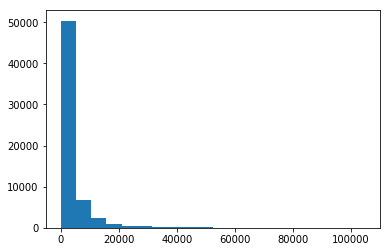

In [15]:
plt.hist(df2['TOTAL'], bins=20);

### Chaoticness of week vs weekend

Std Dev as a measure of 'chaoticness' of a station:

In [122]:
grp4 = df2.groupby(['STATION','WKDAY_WKEND'])['TOTAL'].std().unstack()
# grp4['WKEND_DIFF'] = grp4['wkday'] - grp4['wkend'] 

In [123]:
grp4.head()

WKDAY_WKEND,wkday,wkend
STATION,,
1 AV,4200.039851,3197.111222
103 ST,5222.886262,2872.175267
103 ST-CORONA,2569.509990,1521.139438
104 ST,427.165616,156.746713
110 ST,1844.339882,1148.413614


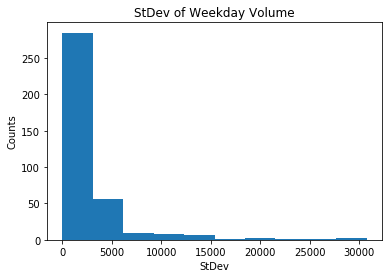

In [132]:
plt.hist(grp4['wkday'])
plt.xlabel('StDev')
plt.ylabel('Counts')
plt.title('StDev of Weekday Volume');

Wants low-StDev stations, coupled with high-volume. This graph doesn't tell us much on its own.

Also compute asbsolute & % difference between weekend and weekday ridership:

In [126]:
grp5 = df2.groupby(['STATION','WKDAY_WKEND'])['TOTAL'].sum().unstack()
grp5['WKEND_DIFF'] = grp5['wkday'] - grp5['wkend']
# grp5.sort_values('WKEND_DIFF').head()

In [65]:
grp5.head()

WKDAY_WKEND,wkday,wkend,WKEND_DIFF
STATION,,,
1 AV,918749.0,277738.0,641011.0
103 ST,1109699.0,238944.0,870755.0
103 ST-CORONA,681099.0,187607.0,493492.0
104 ST,87381.0,16536.0,70845.0
110 ST,409387.0,100726.0,308661.0


Can merge these df's with a previous one (grp4) to compare these stations with TOTAL volume

In [127]:
grp6 = pd.merge(grp2, grp4, on='STATION')
grp6 = pd.merge(grp6, grp5, on='STATION')
grp6.rename(columns={'wkday_x':'WKDAY_std', 'wkend_x':'WKEND_std', 'wkday_y':'WKDAY_TOTAL','wkend_y':'WKEND_TOTAL'}, inplace=True)

In [136]:
grp6['WKEND_DIFF%'] = grp6['WKEND_DIFF'] / grp6['TOTAL']
grp6['WKEND%'] = grp6['WKEND_TOTAL'] / grp6['TOTAL']
grp6['WKDAY_rsd'] = grp6['WKDAY_std'] / grp6['TOTAL']

In [137]:
grp6.head()

,STATION,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,WKDAY_std,WKEND_std,WKDAY_TOTAL,WKEND_TOTAL,WKEND_DIFF,WKEND_DIFF%,WKEND%,WKDAY_rsd
0,1 AV,571582.0,624905.0,1196487.0,4200.039851,3197.111222,918749.0,277738.0,641011.0,0.535744,0.232128,0.003510
1,103 ST,804844.0,543799.0,1348643.0,5222.886262,2872.175267,1109699.0,238944.0,870755.0,0.645653,0.177174,0.003873
2,103 ST-CORONA,503029.0,365677.0,868706.0,2569.509990,1521.139438,681099.0,187607.0,493492.0,0.568077,0.215961,0.002958
3,104 ST,71630.0,32287.0,103917.0,427.165616,156.746713,87381.0,16536.0,70845.0,0.681746,0.159127,0.004111
4,110 ST,278100.0,232013.0,510113.0,1844.339882,1148.413614,409387.0,100726.0,308661.0,0.605084,0.197458,0.003616


Some low-volume stations have high RSD. Zoom in on y-axis

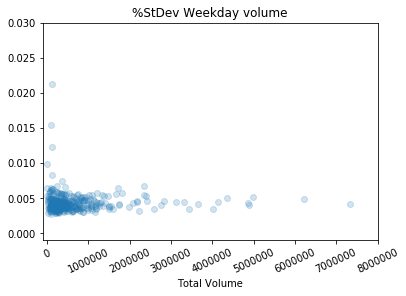

In [149]:
plt.scatter(grp6['TOTAL'],grp6['WKDAY_rsd'], alpha=0.2)
plt.xlabel('Total Volume')
# plt.ylabel('RSD')
plt.axis([-100000, 8000000, -0.001, 0.03])
plt.xticks(rotation=25)
plt.title('%StDev Weekday volume');

**List of stations**

Stations with most consistent weekday traffic:

In [152]:
grp6.sort_values('WKDAY_rsd').head(15)[['STATION', 'TOTAL', 'WKDAY_rsd']]

,STATION,TOTAL,WKDAY_rsd
169,BUSHWICK AV,102433.0,0.002727
340,ST LAWRENCE AV,198099.0,0.002816
280,MORISN AV/SNDVW,299663.0,0.002822
367,WILSON AV,232021.0,0.002849
141,BEACH 44 ST,38405.0,0.002887
2,103 ST-CORONA,868706.0,0.002958
286,MYRTLE-WYCKOFF,868279.0,0.002990
39,207 ST,260267.0,0.002995
252,JEFFERSON ST,270072.0,0.002999
162,BROADWAY JCT,424602.0,0.003004


Stations with low weekend % (filtered for a minimum total volume)

In [163]:
grp6[grp6['TOTAL'] > 10000].sort_values('WKEND%').head(15)[['STATION', 'TOTAL', 'WKEND%']]

,STATION,TOTAL,WKEND%
183,CLARK ST,159947.0,0.000306
241,HOYT ST,246465.0,0.000860
317,PENNSYLVANIA AV,129278.0,0.008362
257,JUNIUS ST,89339.0,0.009492
347,SUTTER AV-RUTLD,272388.0,0.011451
332,SARATOGA AV,209641.0,0.012254
293,NEW LOTS AV,228059.0,0.012900
80,57 ST,464740.0,0.023026
69,47-50 STS ROCK,2360332.0,0.025014
64,42 ST-BRYANT PK,1716559.0,0.047002


#### Horizontal Bar Chart of Large Weekday-Weekend Difference Stations

In [164]:
hb_ser = grp5.sort_values('WKEND_DIFF').tail(15)['WKEND_DIFF']
hb_data = hb_ser.values
hb_labels = hb_ser.index

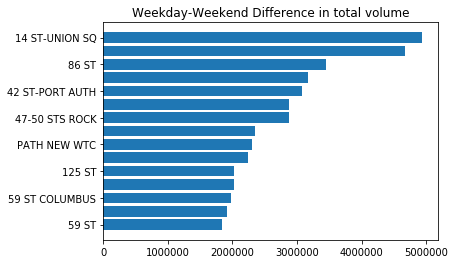

In [165]:
plt.figsize=[20,8]
ys = np.arange(len(hb_data))
plt.barh(ys, hb_data)
plt.title('Weekday-Weekend Difference in total volume')
ax = plt.gca()
ax.set_yticklabels(hb_labels);
# plt.yticks = (ys, hb_labels)

### Sum by Date

To make sure there are no anomalies on a certain day

In [166]:
grp3 = df2.groupby(['STATION','DATE'])['ENTRY_DIFFS','EXIT_DIFFS','TOTAL'].sum().reset_index()

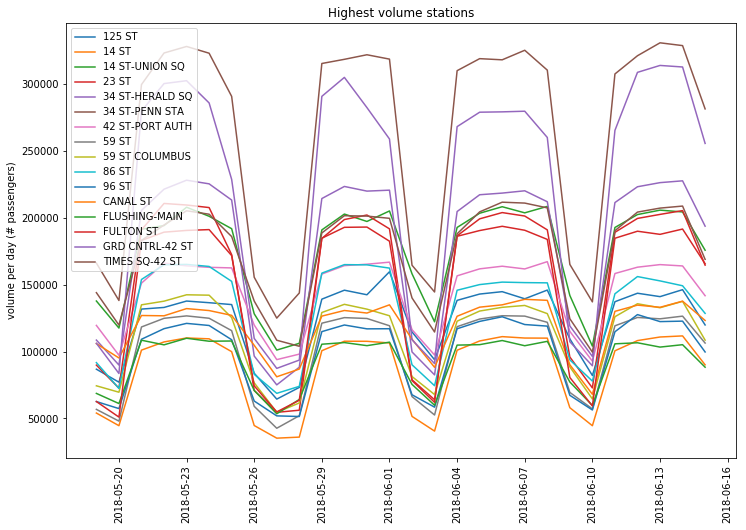

In [167]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Highest volume stations');

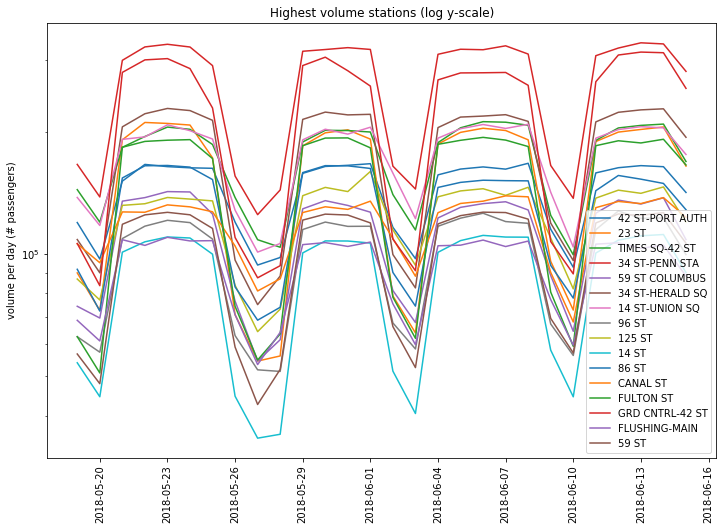

In [206]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.semilogy(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Highest volume stations (log y-scale)');

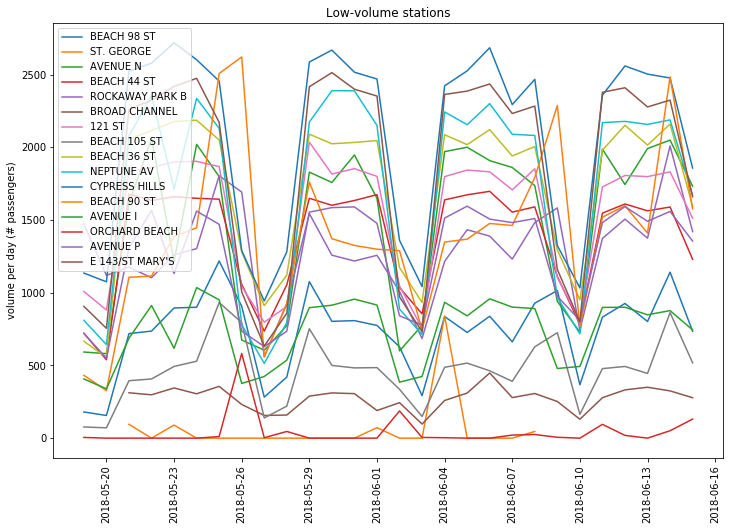

In [168]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in lowest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Low-volume stations');

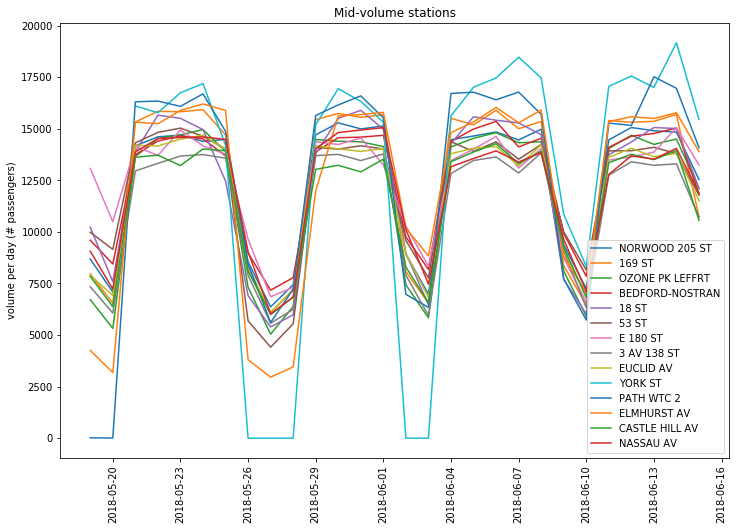

In [173]:
# ** If we want to keep this chart, change x-axis to 'Mon, Tues, Wed, etc'?

fig, ax = plt.subplots(figsize=[12,8])

for s in mid_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
    plt.plot(xs, dum_df['TOTAL'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('volume per day (# passengers)')
    plt.title('Mid-volume stations');

### Average by Day of week

In [174]:
grp1 = df2.groupby(['STATION', 'DAY_OF_WEEK'])['ENTRY_DIFFS','EXIT_DIFFS','TOTAL'].mean().reset_index()

In [175]:
xlabels_dow = calendar.day_name[:]

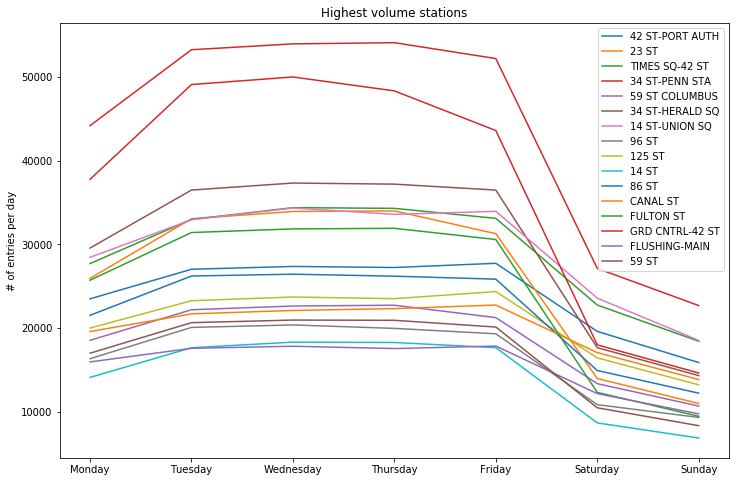

In [176]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp1[grp1['STATION'] == s]
    xs = dum_df['DAY_OF_WEEK']
#     week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['TOTAL'], label=s)

# xticklocs = ax.get_xticks()
plt.xticks(np.arange(7), xlabels_dow)
# plt.xticks(rotation=90)
plt.legend()
plt.ylabel('# of entries per day')
plt.title('Highest volume stations');

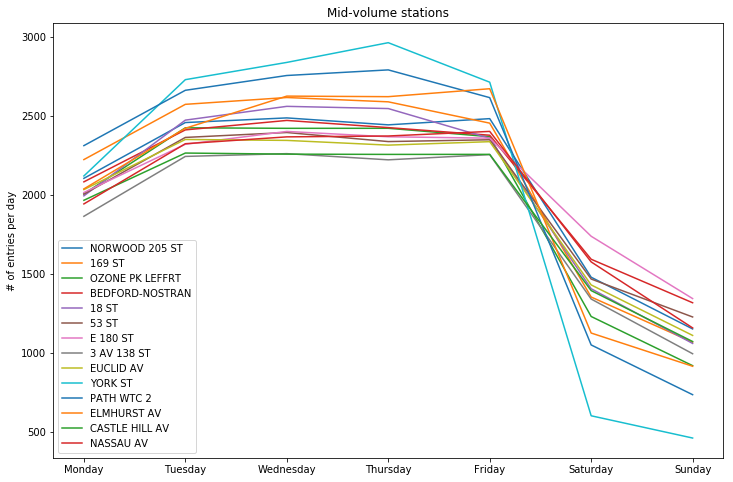

In [177]:
fig, ax = plt.subplots(figsize=[12,8])

for s in mid_vol:
    dum_df = grp1[grp1['STATION'] == s]
    xs = dum_df['DAY_OF_WEEK']
#     week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['TOTAL'], label=s)

# xticklocs = ax.get_xticks()
plt.xticks(np.arange(7), xlabels_dow)
# plt.xticks(rotation=90)
plt.legend()
plt.ylabel('# of entries per day')
plt.title('Mid-volume stations');

### Heatmap: volume of traffic by day of week & time of day, for a given station

In [178]:
vmax = df2['TOTAL'].max() * 1.5
vmin = df2['TOTAL'].min()

In [179]:
xlabel_hm = [str(int(x)) + 'h' for x in np.linspace(0,20,6)]
ylabel_hm = calendar.day_name[:]

In [180]:
def heatmap_data_by_dow(s, data_col, dow):
    '''Inputs:
        station key s 
        data_col (e.g. 'ENTRY_DIFFS')
        dow (day of weeks, an integer from 0-6, with 0 being Monday)
    Returns: 
        Dataframe summed over that day of week, grouped by time, for that station, from that data_col'''
    dum_df = df2[(df2['DAY_OF_WEEK'] == dow) & (df2['STATION'] == s)]
    return dum_df.groupby('TIME')[data_col].sum()

Use total. Make a heatmap for each station in highest_vol list.

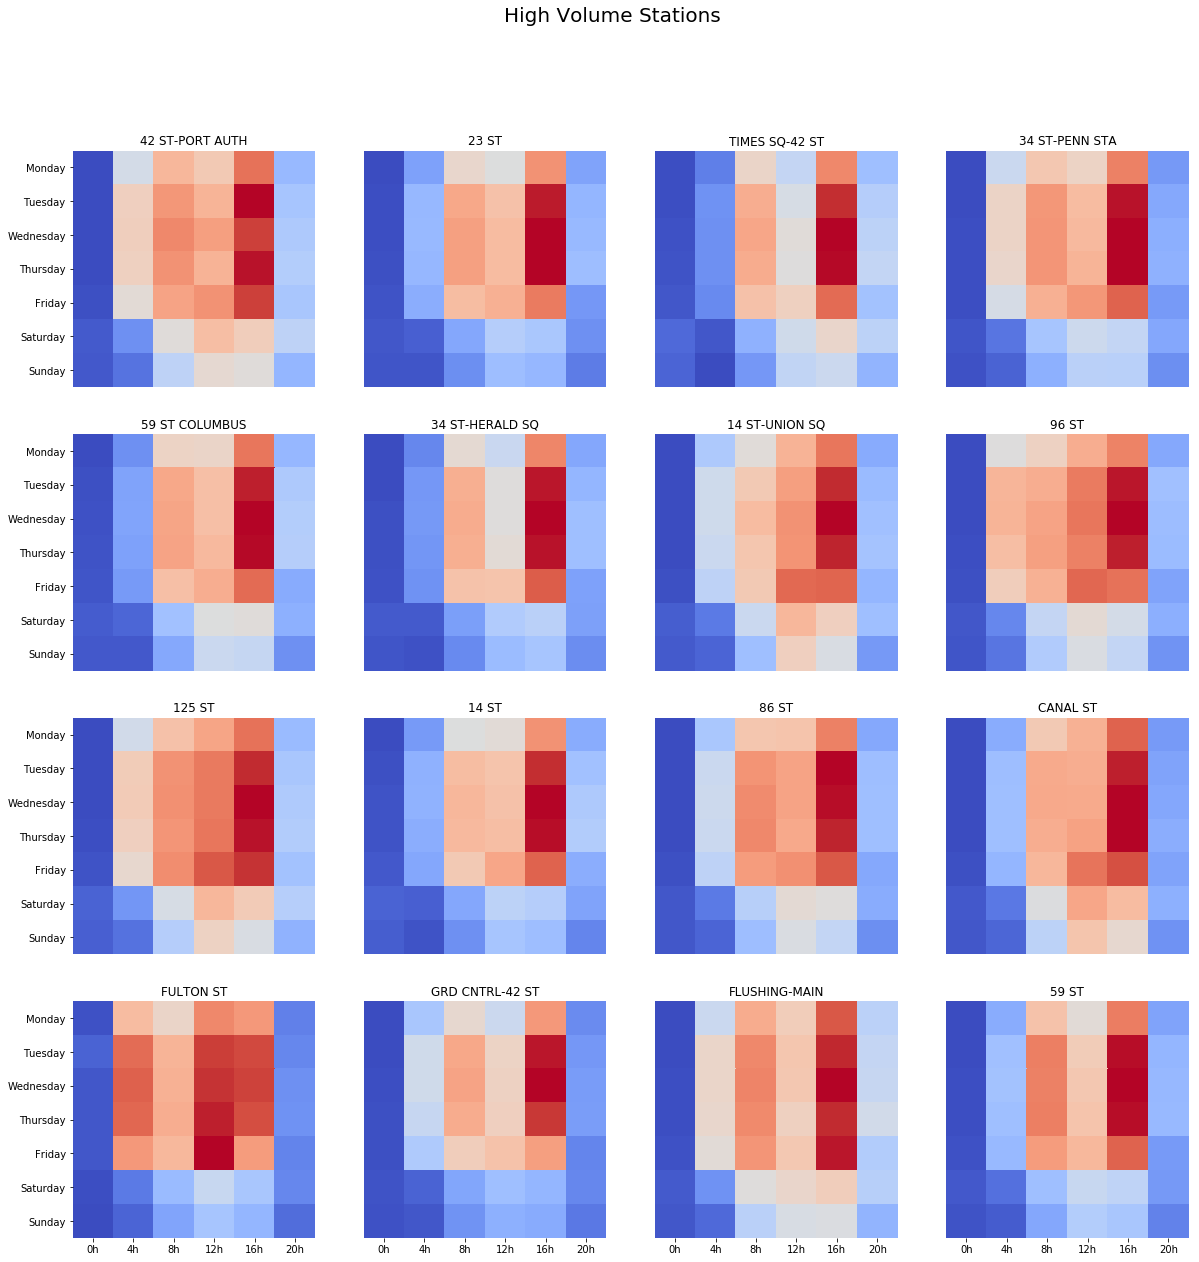

In [184]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
plt.suptitle('High Volume Stations', fontsize=20)

for i, s in enumerate(highest_vol):
    plt.subplot(4,4,i+1)
    
    if i % 4 == 0:
        ylabel=ylabel_hm
    else:
        ylabel=False
    
    if i > 11:
        xlabel=xlabel_hm
    else:
        xlabel=False
    
    hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
    sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, 
                cbar=False, cmap='coolwarm')
#     sns.heatmap(hm_data, cbar=False)
    plt.title(s)
    



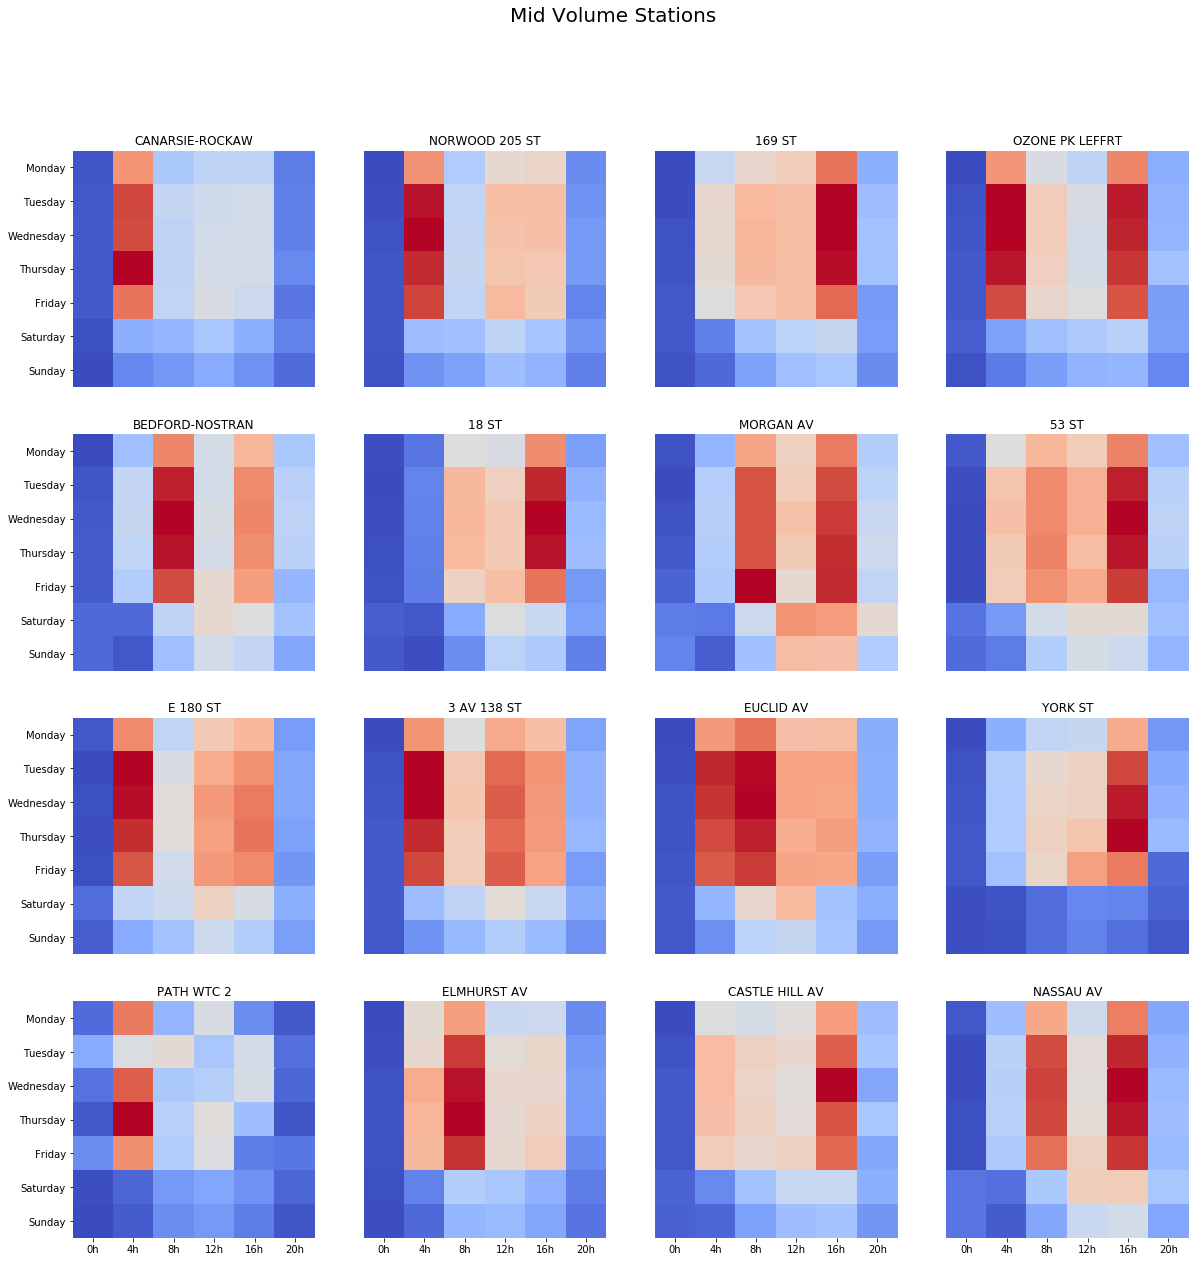

In [199]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
plt.suptitle('Mid Volume Stations', fontsize=20)

for i, s in enumerate(mid_vol):
    plt.subplot(4,4,i+1)
    
    if i % 4 == 0:
        ylabel=ylabel_hm
    else:
        ylabel=False
    
    if i > 11:
        xlabel=xlabel_hm
    else:
        xlabel=False
    
    hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
    sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, 
                cbar=False, cmap='coolwarm')
    # don't use vmax / vmin here, otherwise most stations' plots are just blue
    
    plt.title(s)
    

Text(0.5,1,'Low volume (BEACH 98 ST)')

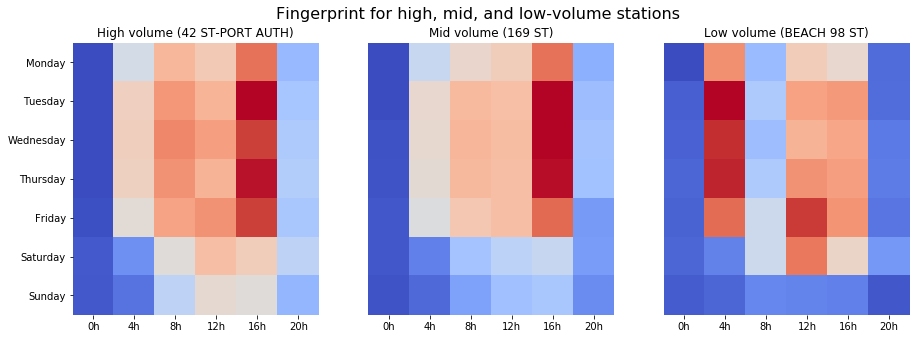

In [197]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
plt.suptitle('Fingerprint for high, mid, and low-volume stations', fontsize=16)

plt.subplot(1,3,1)
hm_data1 = [heatmap_data_by_dow(highest_vol[0], 'TOTAL', d) for d in range(7)]
sns.heatmap(hm_data1, xticklabels = xlabel_hm, yticklabels=ylabel_hm, 
            cbar=False, cmap='coolwarm') 
plt.title('High volume (' + highest_vol[0] + ')')

plt.subplot(1,3,2)
hm_data2 = [heatmap_data_by_dow(mid_vol[1], 'TOTAL', d) for d in range(7)]
sns.heatmap(hm_data2, xticklabels = xlabel_hm, yticklabels=False, 
            cbar=False, cmap='coolwarm')
plt.title('Mid volume (' + mid_vol[1] + ')')

plt.subplot(1,3,3)
hm_data3 = [heatmap_data_by_dow(lowest_vol[0], 'TOTAL', d) for d in range(7)]
sns.heatmap(hm_data3, xticklabels = xlabel_hm, yticklabels=False, 
            cbar=False, cmap='coolwarm')
plt.title('Low volume (' + lowest_vol[0] + ')')

### Pair Plots

In [201]:
pp_df = grp6[['STATION','TOTAL','WKEND%','WKDAY_rsd']]

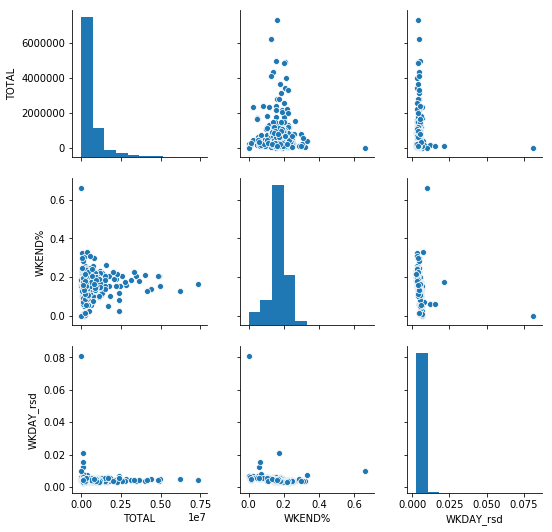

In [205]:
plt.figsize=[20,20]
sns.pairplot(pp_df)

This doesn't show much

In [200]:
grp6.head()

,STATION,ENTRY_DIFFS,EXIT_DIFFS,TOTAL,WKDAY_std,WKEND_std,WKDAY_TOTAL,WKEND_TOTAL,WKEND_DIFF,WKEND_DIFF%,WKEND%,WKDAY_rsd
0,1 AV,571582.0,624905.0,1196487.0,4200.039851,3197.111222,918749.0,277738.0,641011.0,0.535744,0.232128,0.003510
1,103 ST,804844.0,543799.0,1348643.0,5222.886262,2872.175267,1109699.0,238944.0,870755.0,0.645653,0.177174,0.003873
2,103 ST-CORONA,503029.0,365677.0,868706.0,2569.509990,1521.139438,681099.0,187607.0,493492.0,0.568077,0.215961,0.002958
3,104 ST,71630.0,32287.0,103917.0,427.165616,156.746713,87381.0,16536.0,70845.0,0.681746,0.159127,0.004111
4,110 ST,278100.0,232013.0,510113.0,1844.339882,1148.413614,409387.0,100726.0,308661.0,0.605084,0.197458,0.003616
